<a href="https://colab.research.google.com/github/shairaalam19/cs245-fall2023-gm2/blob/maniknarang%2Fsubmission/glide_finetuned_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q 'git+https://github.com/crowsonkb/glide-text2im'

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
#@title Imports
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer
from google.colab import drive

In [ ]:
#@title Device setup
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
# Sampling parameters
prompt = "medium sized brown fluffy dog posing while sitting on a couch" #@param {type:"string"}
batch_size =  1 #@param {type:"number"}
guidance_scale =  8#@param {type:"number"}

#@markdown `upsample_temp` Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 1.0

base_timestep_respacing = '40' #@param {type:"string"}

sr_timestep_respacing = 'fast27'

### GLIDE finetuned model checkpoint

In [ ]:
#@title Create base model.
# Mount Google Drive
drive.mount('/content/drive')

glide_path = '/content/drive/My Drive/base20_new.pt' #@param {type:"string"}
import os
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = base_timestep_respacing # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)

if len(glide_path) > 0:
    assert os.path.exists(
        glide_path
    ), f"Failed to resume from {glide_path}, file does not exist."
    weights = th.load(glide_path, map_location="cpu")
    model, diffusion = create_model_and_diffusion(**options)
    model.load_state_dict(weights)
    print(f"Resumed from {glide_path} successfully.")
else:
    model, diffusion = create_model_and_diffusion(**options)
    model.load_state_dict(load_checkpoint("base", device))
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
print('total base parameters', sum(x.numel() for x in model.parameters()))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Resumed from /content/drive/My Drive/base20_new.pt successfully.
total base parameters 385030726


In [ ]:
#@title Create upsampler model.
sr_glide_path = '/content/drive/My Drive/upsample40.pt' #@param {type:"string"}


options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = sr_timestep_respacing # use 27 diffusion steps for very fast sampling

if len(sr_glide_path) > 0:
    assert os.path.exists(
        sr_glide_path
    ), f"Failed to resume from {sr_glide_path}, file does not exist."
    weights = th.load(sr_glide_path, map_location="cpu")
    model_up, diffusion_up = create_model_and_diffusion(**options_up)
    model_up.load_state_dict(weights)
    print(f"Resumed from {sr_glide_path} successfully.")
else:
    model_up, diffusion_up = create_model_and_diffusion(**options)
    model_up.load_state_dict(load_checkpoint("upsample", device))

if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

Resumed from /content/drive/My Drive/upsample40.pt successfully.
total upsampler parameters 398361286


In [ ]:
#@title Util
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

  0%|          | 0/38 [00:00<?, ?it/s]

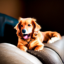

In [ ]:
#@title Base model sampling
##############################
# Sample from the base model #
##############################
# Create the text tokens to feed to the model.

tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options["text_ctx"]
)
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options["text_ctx"]
)
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

def cfg_model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)
# Sample from the base model.


full_batch_size = batch_size * 2
model.del_cache()
samples = diffusion.plms_sample_loop(
    cfg_model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/25 [00:00<?, ?it/s]

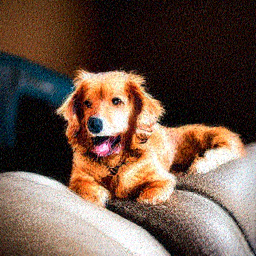

In [ ]:
#@title Upsampling 4x

##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.plms_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

### Evaluate FID scores

In [ ]:
!git clone https://github.com/shairaalam19/cs245-fall2023-gm2.git

finetuned_glide_images_path_64x64 = 'cs245-fall2023-gm2/images/finetuned_glide/upsampler40/64x64'
original_glide_images_path_64x64 = 'cs245-fall2023-gm2/images/original_glide/64x64'
real_glide_images_path_64x64 = 'cs245-fall2023-gm2/images/real_photos/64x64'

finetuned_glide_images_path_256x256 = 'cs245-fall2023-gm2/images/finetuned_glide/upsampler40/256x256'
original_glide_images_path_256x256 = 'cs245-fall2023-gm2/images/original_glide/256x256'
real_glide_images_path_256x256 = 'cs245-fall2023-gm2/images/real_photos/256x256'

# Calculate FID scores for 64x64 images
print("FIDs for real and original GLIDE generated photographs (64x64)")
compare_image_folders(real_glide_images_path_64x64, original_glide_images_path_64x64)
print("FIDs for real and finetuned GLIDE generated photographs (64x64)")
compare_image_folders(real_glide_images_path_64x64, finetuned_glide_images_path_64x64)

# Caluculate FID scores for 256x256 images
print("FIDs for real and original GLIDE generated photographs (256x256)")
compare_image_folders(real_glide_images_path_256x256, original_glide_images_path_256x256)
print("FIDs for real and finetuned GLIDE generated photographs (256x256)")
compare_image_folders(real_glide_images_path_256x256, finetuned_glide_images_path_256x256)

fatal: destination path 'cs245-fall2023-gm2' already exists and is not an empty directory.
FIDs for real and original GLIDE generated photographs (64x64)
1/1 [==============================] - 0s 33ms/step
FID for real photograph 000.jpg and generated photograph 000.png: 117.32136041189621
1/1 [==============================] - 0s 26ms/step
FID for real photograph 001.jpg and generated photograph 001.png: 301.8550853876019
1/1 [==============================] - 0s 28ms/step
FID for real photograph 002.jpg and generated photograph 002.png: 360.7659836132244
1/1 [==============================] - 0s 52ms/step
FID for real photograph 003.jpg and generated photograph 003.png: 347.0794875578431
Average FID: 281.7554792426414
FIDs for real and finetuned GLIDE generated photographs (64x64)
1/1 [==============================] - 0s 29ms/step
FID for real photograph 000.jpg and generated photograph 000.png: 117.00608230150416
1/1 [==============================] - 0s 25ms/step
FID for real phot